### WIP Methylation Statistical Analysis

This code analyzes a multi-tissue DNA methylation dataset from mice, sourced from ['Multi-tissue DNA methylation age predictor in mouse'](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1203-5). It calculates average methylation rate, depth, and identifies tissue-specific and age-related differentiations in the samples. By employing  statistical techniques, this code will provide valuable insights into DNA methylation patterns and their association with aging processes. 

In [23]:
import gzip
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from typing import Tuple, List
from tabulate import tabulate

In [7]:
pd.set_option('display.max_rows', None)
directory = 'data/GSE93957_RAW/'

### Load Data & Build Dataframe

The build_df function generates a pandas DataFrame from a specified sample name. It initializes an empty DataFrame and defines column names. It iterates through files in the directory, checking for gzip format and matching sample name. Data is read using read_csv, with tab as separator, and stored in a temporary DataFrame. If the main DataFrame is empty, the data is directly assigned. The function returns the compiled DataFrame from matching files.

In [8]:

sample_list = ["Lung", "Heart", "Liver", "Cortex"]

def build_df(filename) -> pd.DataFrame:
    # Create empty DataFrame to be filled
    df = pd.DataFrame()
    columns_names = ['chromosome', 's_loc', 'e_loc', 'methyl_rate', 's_depth', 'e_depth']

    file_path = os.path.join(directory, filename)
    # Open the gzipped file in text mode
    with gzip.open(file_path, 'rt') as file:  
        print(file_path)
        df = pd.read_csv(file_path, sep="\t", header=None, names=columns_names, low_memory=False)

        # Add Column for CG-Sites
        loc_list = df['s_loc'].tolist()
        cg_list = []
        for idx in range(len(loc_list)):
            # check if index isn't the last value, and check if next methylated read is sequential to current index
            if idx < len(loc_list)-1 and (loc_list[idx] == loc_list[idx+1]-1):
                cg_list.append(True)
            # check if index isn't the first value, and check if the previous methylated read is sequential to current index
            elif idx > 0 and (loc_list[idx] == loc_list[idx-1]+1):
                cg_list.append(True)
            # Append false otherwise
            else:
                cg_list.append(False)
        df['CG site'] = cg_list

    return df

### Define Functions to parse data

In [9]:
def build_result(test = False):
    column_names = ['id', 'age', 'tissue', 'num_sites', 'ave depth', 'ave methylation', 'ave methylation > 2 depth', 'ave methylation > 5 depth']
    result = pd.DataFrame(columns=column_names)
    
    
    if not test:
        for filename in os.listdir(directory):
            _build_result_helper(filename, result)
    else: 
        filename = "GSM2465667_M04NB_1wk_Liver.cov.txt.gz"
        _build_result_helper(filename, result)
        
    return result

def _build_result_helper(filename, result):
    df = build_df(filename)
    length = len(df)
    depth = (df['s_depth'] + df['e_depth']).mean()
    mean = df.loc[df['CG site'] == True, 'methyl_rate'].mean()
    
    # Get the average methylation for rows with read_count >= 2 & read_count <= 100
    df = df.drop(df[df['e_depth'] + df['s_depth'] < 2].index)
    df = df.drop(df[df['e_depth'] + df['s_depth'] > 100].index)
    two_depth_mean = df.loc[df['CG site'] == True, 'methyl_rate'].mean()

    # Get the average methylation for rows with read_count >= 5 & read_count <= 100
    df = df.drop(df[df['e_depth'] + df['s_depth'] < 5].index)
    five_depth_mean = df.loc[df['CG site'] == True, 'methyl_rate'].mean()

    # Split the filename into id and age_sample
    splits = filename.split("_")
    id = splits[0]+"_"+splits[1]
    age = splits[2]
    tissue = splits[3].split(".")[0]
    result.loc[len(result)] = [id, age, tissue, length, depth, mean, two_depth_mean, five_depth_mean]


### Load the data and parse the results

Parsing through all the data takes about two minutes.

In [11]:
# Perform statistical analysis and build a 'result DataFrame' that will be saved
df = build_result()

data/GSE93957_RAW/GSM2465633_M00018724_27wk_Liver.cov.txt.gz
data/GSE93957_RAW/GSM2465619_M00018362_41wk_Cortex.cov.txt.gz
data/GSE93957_RAW/GSM2465667_M04NB_1wk_Liver.cov.txt.gz
data/GSE93957_RAW/GSM2465627_M00018381_41wk_Cortex.cov.txt.gz
data/GSE93957_RAW/GSM2465631_M00018724_27wk_Cortex.cov.txt.gz
data/GSE93957_RAW/GSM2465653_M02NB_1wk_Lung.cov.txt.gz
data/GSE93957_RAW/GSM2465636_M00018752_27wk_Heart.cov.txt.gz
data/GSE93957_RAW/GSM2465632_M00018724_27wk_Heart.cov.txt.gz
data/GSE93957_RAW/GSM2465637_M00018752_27wk_Liver.cov.txt.gz
data/GSE93957_RAW/GSM2465625_M00018363_41wk_Liver.cov.txt.gz
data/GSE93957_RAW/GSM2465668_M04NB_1wk_Lung.cov.txt.gz
data/GSE93957_RAW/GSM2465662_M0420527_14wk_Heart.cov.txt.gz
data/GSE93957_RAW/GSM2465665_M04NB_1wk_Cortex.cov.txt.gz
data/GSE93957_RAW/GSM2465642_M00018754_27wk_Lung.cov.txt.gz
data/GSE93957_RAW/GSM2465676_M0520522_14wk_Lung.cov.txt.gz
data/GSE93957_RAW/GSM2465621_M00018362_41wk_Liver.cov.txt.gz
data/GSE93957_RAW/GSM2465675_M0520522_14wk_Liv

In [12]:
df.sort_values("age", ignore_index=True, inplace=True)
# Display Results Table in ASCII format:
#pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')
#print(pdtabulate(df))
df

,id,age,tissue,num_sites,ave depth,ave methylation,ave methylation > 2 depth,ave methylation > 5 depth
0,GSM2465674_M0520522,14wk,Heart,4719569,26.478823,34.068898,33.398083,34.538635
1,GSM2465658_M0420525,14wk,Heart,4650887,12.917845,34.174385,34.346192,36.191680
2,GSM2465673_M0520522,14wk,Cortex,3993331,12.758077,35.864310,36.232565,37.470658
3,GSM2465676_M0520522,14wk,Lung,3833871,12.380396,34.678738,35.391674,37.767141
4,GSM2465657_M0420525,14wk,Cortex,4205076,14.687372,35.974207,36.301597,37.987918
5,GSM2465663_M0420527,14wk,Liver,4239585,10.794067,34.930300,35.039475,36.319846
6,GSM2465660_M0420525,14wk,Lung,4143370,14.824189,34.019018,34.253134,35.615555
7,GSM2465661_M0420527,14wk,Cortex,4353542,19.095015,35.497980,35.728867,37.005476
8,GSM2465675_M0520522,14wk,Liver,3984791,9.920883,34.910159,35.260631,36.783023
9,GSM2465664_M0420527,14wk,Lung,4017025,14.191690,34.352192,34.860959,36.634177


In [13]:
df[(df['age']=='27wk') & (df['tissue']=='Cortex')]

,id,age,tissue,num_sites,ave depth,ave methylation,ave methylation > 2 depth,ave methylation > 5 depth
26,GSM2465635_M00018752,27wk,Cortex,4189271,17.318348,35.768538,36.043794,37.530824
27,GSM2465639_M00018754,27wk,Cortex,4182114,15.634243,36.432456,36.907237,38.767288
29,GSM2465643_M0112371,27wk,Cortex,3980861,13.733747,35.791901,36.013443,36.952836
34,GSM2465669_M0512375,27wk,Cortex,4136638,15.853547,35.217983,35.212114,35.383589
38,GSM2465631_M00018724,27wk,Cortex,4086565,15.372909,36.412410,36.922754,38.977554


In [ ]:
# Save results
df.to_csv('result.csv', index=False)

## Methylation rates by age
Lets calculate the average methylation rate for each age group

In [14]:
column_names = ['age', 'num_sites', 'ave depth', 'ave methylation', 'ave methylation > 2 depth', 'ave methylation > 5 depth']
age_df = pd.DataFrame(columns=column_names)

age_list = df['age'].unique()
for age in age_list:
    num_sites = df[df['age'] == age]['num_sites'].sum()
    ave_depth = df[df['age'] == age]['ave depth'].mean()
    ave_meth = df[df['age'] == age]['ave methylation'].mean()
    ave_meth_2 = df[df['age'] == age]['ave methylation > 2 depth'].mean()
    ave_meth_5 = df[df['age'] == age]['ave methylation > 5 depth'].mean()
    age_df.loc[len(age_df.index)] = [age, num_sites, ave_depth, ave_meth, ave_meth_2, ave_meth_5]

age_df


,age,num_sites,ave depth,ave methylation,ave methylation > 2 depth,ave methylation > 5 depth
0,14wk,50404726,14.369817,34.766618,35.002258,36.531422
1,1wk,57377240,14.816588,33.302520,33.603920,34.978661
2,27wk,80234281,12.114445,35.073280,35.537200,37.495350
3,41wk,66345571,13.723043,34.848199,35.194057,36.797020


In [15]:
print(age_df['ave methylation'].mean())
print(age_df['ave methylation > 2 depth'].mean())
print(age_df['ave methylation > 5 depth'].mean())

34.49765411514188
34.83435894494286
36.45061328118506


grouped_data = df.groupby('tissue')['ave'].apply(list)

## Graphing & Data Visualization

Lets visualize the trends and range of values provided by the methylation data

In [ ]:
# initialize iterable list for graphs
age_list = df['age'].unique()
unique_tissues = df['tissue'].unique()  
color_map = {tissue: f'C{i}' for i, tissue in enumerate(unique_tissues)}

##### **Box-and-whisker Plot**:

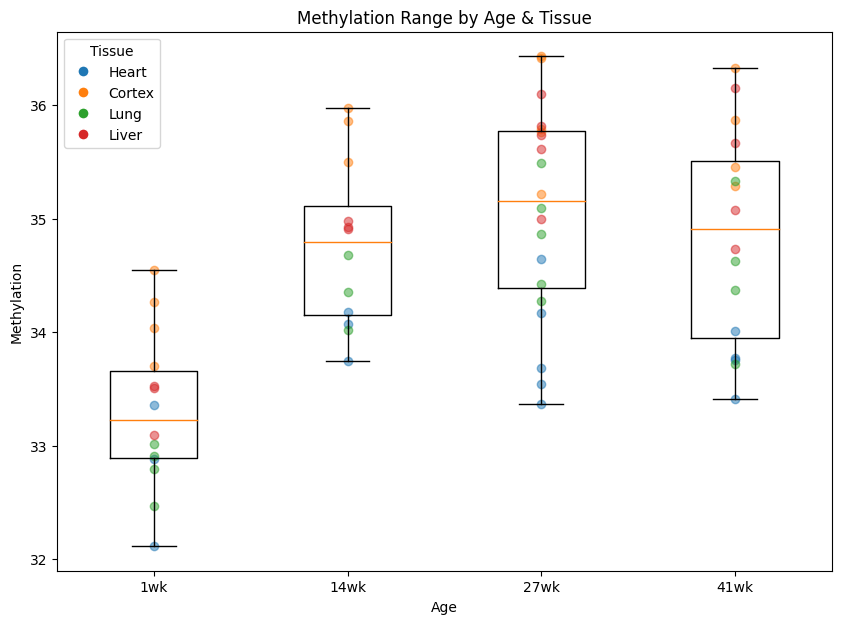

In [56]:
# Setup overall figure and add a single plot to it
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot()


# Convert the df into series and plot said series to boxplots
box_data = df.groupby('age', sort=False)['ave methylation'].apply(list)
data = box_data.values
data[0],data[1] = data[1],data[0]
bp = ax.boxplot(data)

# Add scatter plots for each tissue
for i, age in enumerate(age_list):
    age_data = df[df['age'] == age]
    for tissue in unique_tissues:
        scatter_y = age_data[age_data['tissue'] == tissue]['ave methylation']
        scatter_x = [i+1] * len(scatter_y) # Each y-value from above must have a x-value
        ax.scatter(scatter_x, scatter_y, color=color_map[tissue], alpha=0.5)

# Set x-axis labels
ax.set_xticks(range(1, len(age_list)+1))
ax.set_xticklabels(age_list)

# Set labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Methylation')
ax.set_title('Methylation by Age')

# Create custom legend for tissues
scatter_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[tissue], markersize=8) for tissue in unique_tissues]
plt.legend(scatter_labels, unique_tissues, title='Tissue')

# Label Overall Figure and Display
plt.title('Methylation Range by Age & Tissue')
plt.show();



##### **Linear Regression Plot**:

In [46]:
# First we need to group by 'age' and 'tissue' and calculate the average 'ave_methylation'
grouped_df = df.groupby(['age', 'tissue']).agg({'ave methylation': 'mean'}).reset_index()


# let's convert the 'age' column to a sortable integer column.
grouped_df['age_int'] = grouped_df['age'].str.replace('wk', '').astype(int)

# Now let's sort the DataFrame by this new 'age_int' column.
grouped_df = grouped_df.sort_values(by='age_int')

# If you want to drop the 'age_int' column after sorting, you can do so.
grouped_df.drop('age_int', axis=1, inplace=True)

# Now df_sorted is sorted by age in the order you specified.

grouped_df


,age,tissue,ave methylation
4,1wk,Cortex,34.139432
5,1wk,Heart,32.786160
6,1wk,Liver,33.375350
7,1wk,Lung,32.798255
0,14wk,Cortex,35.778832
1,14wk,Heart,33.998047
2,14wk,Liver,34.939611
3,14wk,Lung,34.349983
8,27wk,Cortex,35.924657
9,27wk,Heart,33.884066


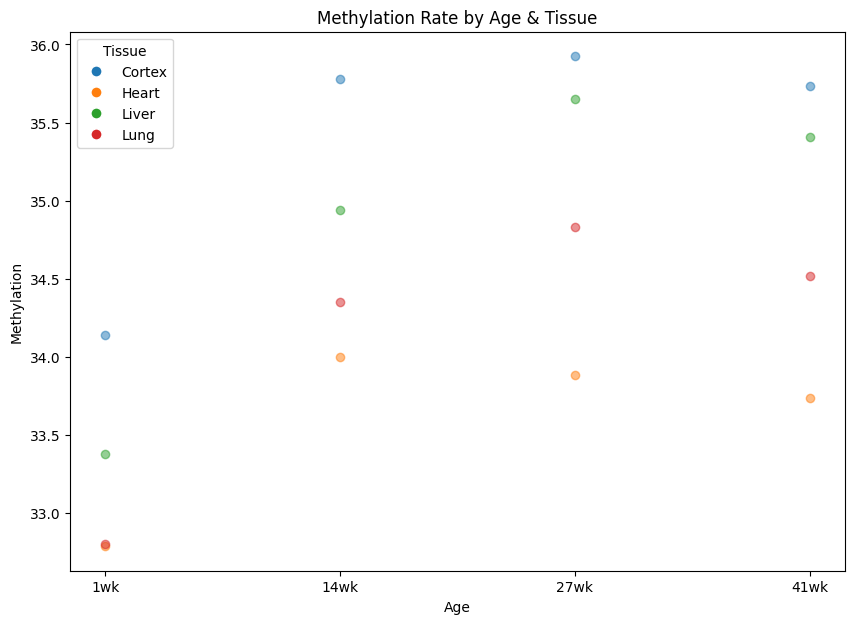

In [54]:
# Setup overall figure and add a single plot to it
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot()

# Group and Prepare dataframe to be graphed


# Get the methylation rate for per every Age and Tissue 
for i, age in enumerate(age_list):
    
    for tissue in unique_tissues:
        ave_methyl = grouped_df[(grouped_df['tissue'] == tissue) & (grouped_df['age'] == age)]['ave methylation'].values[0]
        ax.scatter(i+1, ave_methyl, color=color_map[tissue], alpha=0.5)


# Set x-axis labels
ax.set_xticks(range(1, len(age_list)+1))
ax.set_xticklabels(age_list)

# Set labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Methylation')
ax.set_title('Methylation by Age')

# Create custom legend for tissues
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color=color_map[tissue], linestyle='') for tissue in unique_tissues], 
          labels=list(unique_tissues))

plt.legend(scatter_labels, unique_tissues, title='Tissue')
# Label Overall Figure and Display
plt.title('Methylation Rate by Age & Tissue')
plt.show();


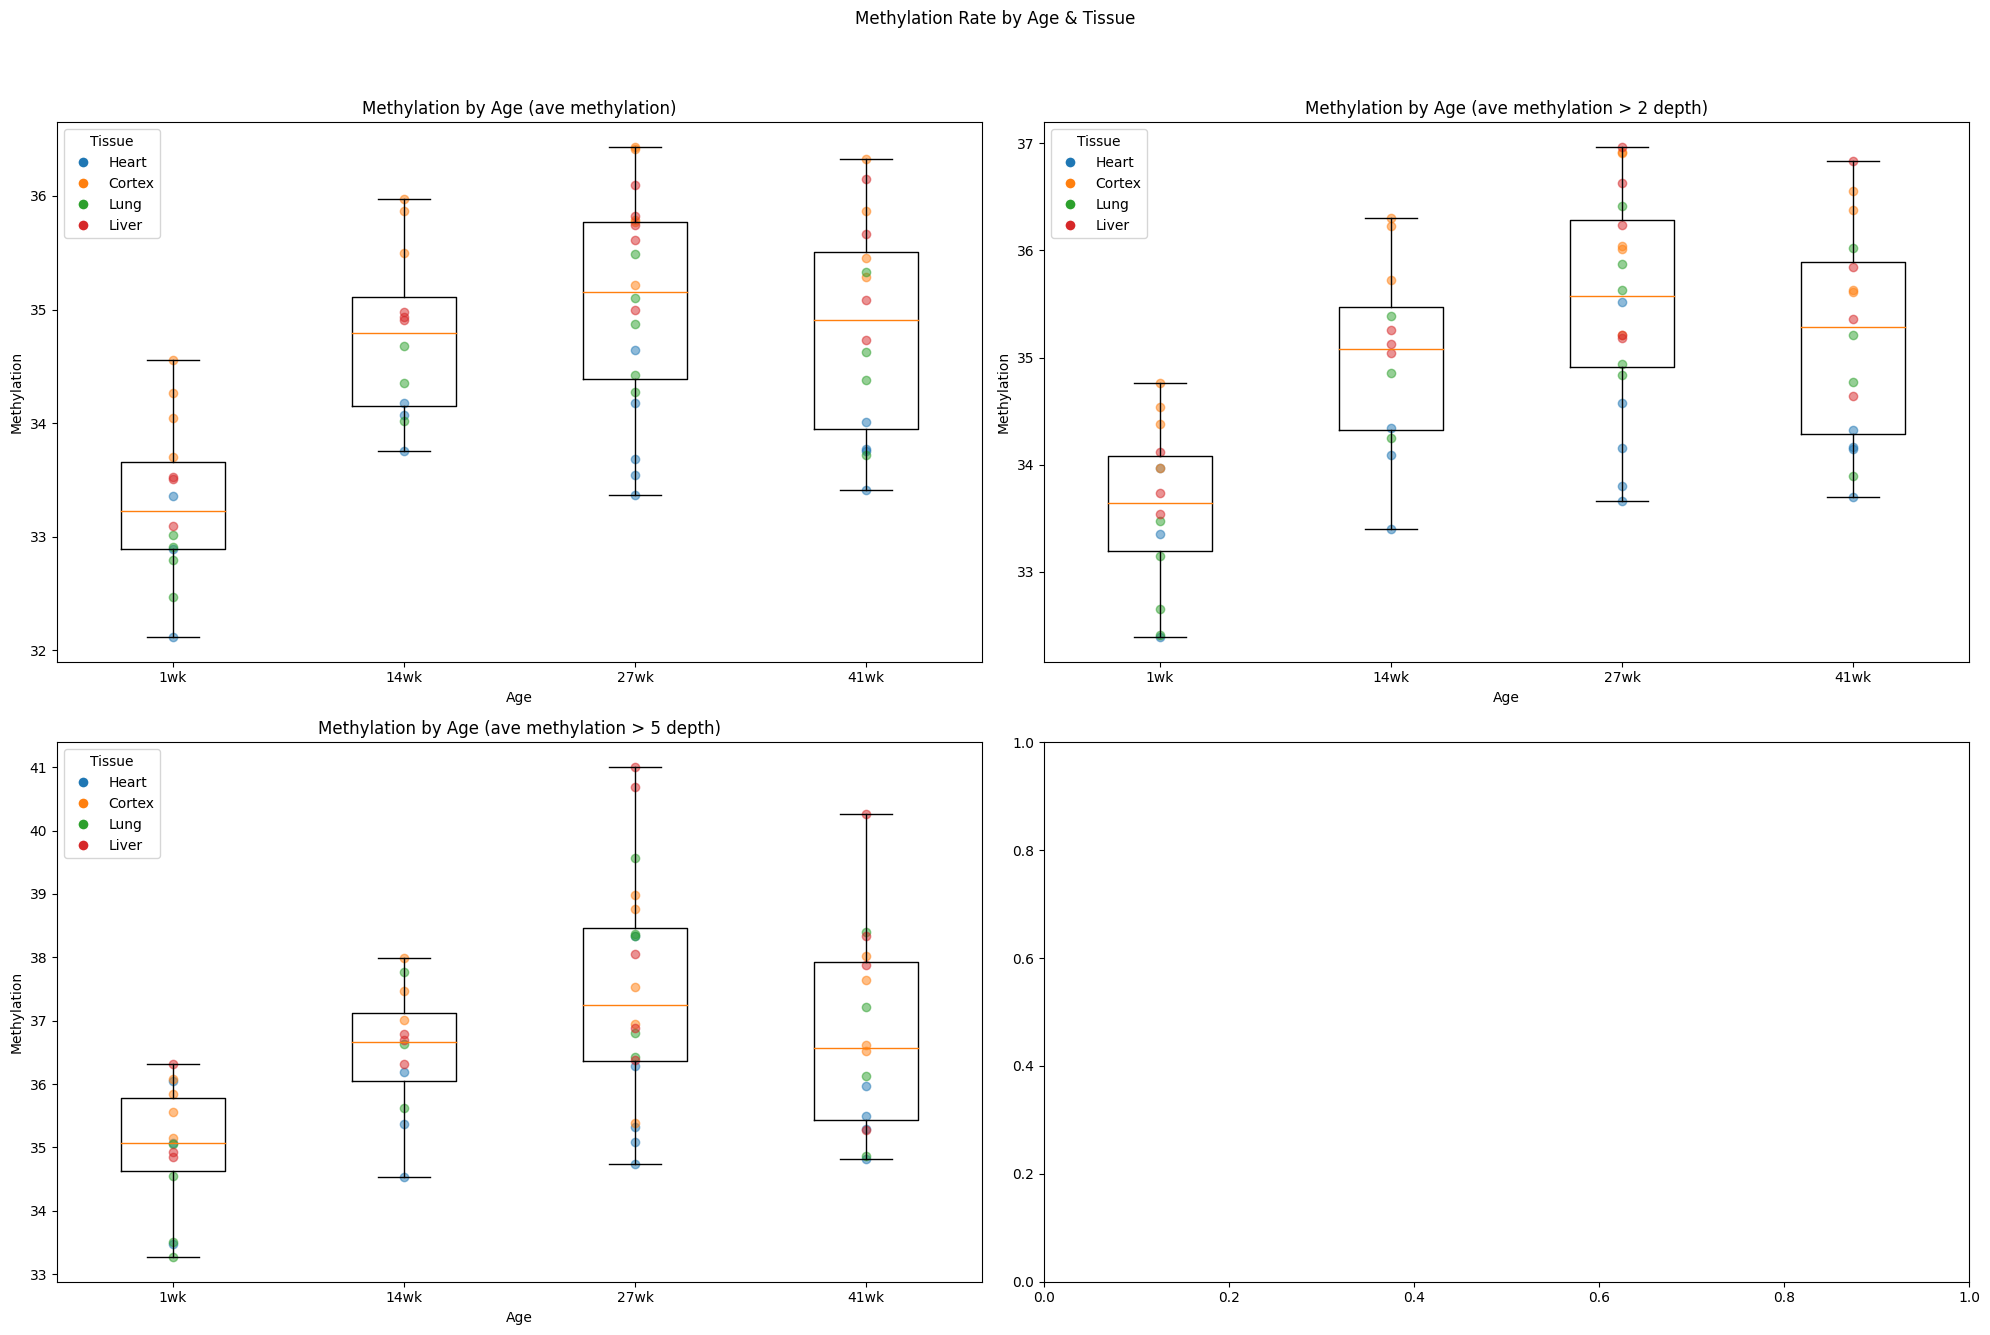

In [ ]:
# Define a function to generate a plot
def generate_plot(ax, df, column_name):
    age_groups = ['1wk', '14wk', '27wk', '41wk']
    box_data = df.groupby('age', sort=False)[column_name].apply(list)
    data = box_data.values
    data[0], data[1] = data[1], data[0]
    bp = ax.boxplot(data)
    unique_tissues = df['tissue'].unique()
    color_map = {tissue: f'C{i}' for i, tissue in enumerate(unique_tissues)}

    for i, age in enumerate(age_groups):
        age_data = df[df['age'] == age]
        for tissue in unique_tissues:
            scatter_data = age_data[age_data['tissue'] == tissue][column_name]
            scatter_x = [i+1] * len(scatter_data)
            ax.scatter(scatter_x, scatter_data, color=color_map[tissue], alpha=0.5)

    ax.set_xticks(range(1, len(age_groups)+1))
    ax.set_xticklabels(age_groups)
    ax.set_xlabel('Age')
    ax.set_ylabel('Methylation')
    ax.set_title(f'Methylation by Age ({column_name})')
    scatter_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[tissue], markersize=8) for tissue in unique_tissues]
    ax.legend(scatter_labels, unique_tissues, title='Tissue')

# Setup overall figure and add subplots to it
fig, axs = plt.subplots(2, 2, figsize =(20, 14))

generate_plot(axs[0, 0], df, 'ave methylation')
generate_plot(axs[0, 1], df, 'ave methylation > 2 depth')
generate_plot(axs[1, 0], df, 'ave methylation > 5 depth')

plt.suptitle('Methylation Rate by Age & Tissue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
